<a href="https://colab.research.google.com/github/njmkl/polynom/blob/main/polynome.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch numpy matplotlib scikit-learn tqdm
import torch, numpy as np, math, random
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

torch.set_default_dtype(torch.float64)
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


Device: cpu


In [ ]:
def generate_quintic_dataset(n_samples=50000, R=3.0):
    X, Y = [], []
    for _ in range(n_samples):
        # случайные корни (реальные и комплексные)
        roots = []
        while len(roots) < 5:
            if random.random() < 0.5 and len(roots) <= 3:  # комплексная пара
                re, im = random.uniform(-R, R), random.uniform(0.2, R)
                roots += [complex(re, im), complex(re, -im)]
            else:
                roots.append(complex(random.uniform(-R, R), 0))
        roots = roots[:5]
        coeffs = np.poly(roots).real  # [1, a4, a3, a2, a1, a0]
        a = coeffs[1:]
        r = np.concatenate([[z.real, z.imag] for z in roots])
        X.append(a)
        Y.append(r)
    return np.array(X), np.array(Y)

X, Y = generate_quintic_dataset(40000)
print("Shape X:", X.shape, "Shape Y:", Y.shape)


Shape X: (40000, 5) Shape Y: (40000, 10)


In [ ]:
import pandas as pd, os

os.makedirs("data", exist_ok=True)

# объединяем коэффициенты и корни в один DataFrame
cols_coeffs = [f"a{i}" for i in range(4, -1, -1)]  # a4..a0
cols_roots  = [f"r{i}_{p}" for i in range(1,6) for p in ("Re","Im")]

df = pd.DataFrame(
    np.concatenate([X, Y], axis=1),
    columns = cols_coeffs + cols_roots
)


df.to_csv("data/quintic_dataset.csv", index=False, float_format="%.8f")
print("Сохранено:", df.shape, "→ data/quintic_dataset.csv")
df.head()


Сохранено: (40000, 15) → data/quintic_dataset.csv


,a4,a3,a2,a1,a0,r1_Re,r1_Im,r2_Re,r2_Im,r3_Re,r3_Im,r4_Re,r4_Im,r5_Re,r5_Im
0,5.010449,8.519133,-13.279863,-67.584064,-119.961119,2.389065,0.000000,-2.556016,1.503121,-2.556016,-1.503121,-1.143740,2.098247,-1.143740,-2.098247
1,0.220860,-2.399991,8.668839,2.458032,-20.506363,-1.998871,0.000000,1.042575,1.771023,1.042575,-1.771023,-1.719652,0.000000,1.412512,0.000000
2,1.075954,-0.963247,0.370408,-0.347454,0.082264,-0.067900,0.526628,-0.067900,-0.526628,-1.795352,0.000000,0.285028,0.000000,0.570171,0.000000
3,1.773928,-7.506084,-27.618939,91.373682,255.368789,-2.134564,0.000000,2.769378,1.560888,2.769378,-1.560888,-2.589060,2.266054,-2.589060,-2.266054
4,2.707643,9.328429,31.458414,43.301268,19.635762,-1.573295,0.000000,0.610122,2.943370,0.610122,-2.943370,-1.246293,0.000000,-1.108299,0.000000


In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# train / val / test
n = len(X)
idx = np.arange(n)
np.random.shuffle(idx)
train, val, test = np.split(idx, [int(0.8*n), int(0.9*n)])

X_train, Y_train = X_scaled[train], Y[train]
X_val,   Y_val   = X_scaled[val],   Y[val]
X_test,  Y_test  = X_scaled[test],  Y[test]

print(f"Train {len(train)}, Val {len(val)}, Test {len(test)}")


Train 32000, Val 4000, Test 4000


In [ ]:
import torch.nn as nn

class QuinticMLP(nn.Module):
    def __init__(self, in_dim=5, hidden=256, depth=5, out_dim=10):
        super().__init__()
        layers = [nn.Linear(in_dim, hidden), nn.GELU()]
        for _ in range(depth-1):
            layers += [nn.Linear(hidden, hidden), nn.GELU(), nn.LayerNorm(hidden)]
        layers += [nn.Linear(hidden, out_dim)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)


In [ ]:
def multiply_poly(p, q):
    n, m = p.shape[-1]-1, q.shape[-1]-1
    out = p.new_zeros(p.shape[0], n+m+1, dtype=torch.complex128)
    for i in range(n+1):
        out[:, i:i+m+1] += p[:, i].unsqueeze(-1) * q
    return out

def coeffs_from_roots(r_reim):
    r = torch.complex(r_reim[:,0::2], r_reim[:,1::2])
    poly = r.new_zeros(r.size(0),1); poly[:,0]=1
    for i in range(5):
        factor = torch.stack([-r[:,i], torch.ones_like(r[:,i])], dim=1)
        poly = multiply_poly(poly, factor)
    coeffs = torch.flip(poly.real, dims=[1])[:,1:]  # a4..a0
    return coeffs

def eval_poly(coeffs, x):
    """
    coeffs: (B, 5) — [a4, a3, a2, a1, a0] для батча
    x:      (K,)   или (B, K) комплекс
    return: (B, K) комплекс
    """
    if x.dim() == 1:              # (K,) -> (1, K) для broadcast
        x = x.unsqueeze(0)
    # разложение коэффициентлв + размер K
    a4, a3, a2, a1, a0 = coeffs.t()   # каждая (B,)
    a4 = a4.unsqueeze(1)              # (B,1)
    a3 = a3.unsqueeze(1)
    a2 = a2.unsqueeze(1)
    a1 = a1.unsqueeze(1)
    a0 = a0.unsqueeze(1)
    return x**5 + a4*x**4 + a3*x**3 + a2*x**2 + a1*x + a0

def eval_poly_deriv(coeffs, x):
    """
    coeffs: (B, 5)
    x:      (K,) или (B, K) комплекс
    return: (B, K) комплекс
    """
    if x.dim() == 1:
        x = x.unsqueeze(0)
    a4, a3, a2, a1, _ = coeffs.t()
    a4 = a4.unsqueeze(1)
    a3 = a3.unsqueeze(1)
    a2 = a2.unsqueeze(1)
    a1 = a1.unsqueeze(1)
    return 5*x**4 + 4*a4*x**3 + 3*a3*x**2 + 2*a2*x + a1

def loss_fn(pred_roots, coeffs_true, lam=0.1):
    coeffs_pred = coeffs_from_roots(pred_roots)
    coef_mse = torch.mean((coeffs_pred - coeffs_true)**2)

    grid = torch.linspace(-2, 2, 6, device=coeffs_true.device)
    Xr, Xi = torch.meshgrid(grid, grid, indexing='ij')
    x = torch.complex(Xr.flatten(), Xi.flatten())  # (K,)
    p_true = eval_poly(coeffs_true, x)             # (B, K)
    p_pred = eval_poly(coeffs_pred, x)             # (B, K)

    residual = torch.mean(torch.abs(p_pred - p_true)**2)
    return coef_mse + lam*residual


In [ ]:
from torch.utils.data import TensorDataset, DataLoader

# датасеты: X_scaled как вход, X (оригинал) как таргет для лосса
train_ds = TensorDataset(torch.from_numpy(X_scaled[train]),
                         torch.from_numpy(X[train]))
val_ds   = TensorDataset(torch.from_numpy(X_scaled[val]),
                         torch.from_numpy(X[val]))

train_loader = DataLoader(train_ds, batch_size=512, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=512)

model = QuinticMLP().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, 50)
best_val = 1e9

for epoch in range(50):
    model.train()
    for xb_scaled, xb_orig in train_loader:
        xb_scaled, xb_orig = xb_scaled.to(device), xb_orig.to(device)
        pred = model(xb_scaled)
        loss = loss_fn(pred, xb_orig, lam=0.1)
        opt.zero_grad(); loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
    scheduler.step()

    # валидация
    model.eval()
    with torch.no_grad():
        val_loss = 0.0
        for xb_scaled, xb_orig in val_loader:
            xb_scaled, xb_orig = xb_scaled.to(device), xb_orig.to(device)
            val_loss += loss_fn(model(xb_scaled), xb_orig).item()
    val_loss /= len(val_loader)
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), "best_mlp.pt")
    print(f"Epoch {epoch+1:02d} | val_loss={val_loss:.3e}")


Epoch 01 | val_loss=2.261e+02
Epoch 02 | val_loss=6.010e+01
Epoch 03 | val_loss=9.251e+01
Epoch 04 | val_loss=5.214e+01
Epoch 05 | val_loss=4.128e+01
Epoch 06 | val_loss=1.390e+02
Epoch 07 | val_loss=5.038e+01
Epoch 08 | val_loss=3.246e+01
Epoch 09 | val_loss=2.873e+01
Epoch 10 | val_loss=2.449e+01
Epoch 11 | val_loss=3.921e+01
Epoch 12 | val_loss=3.448e+01
Epoch 13 | val_loss=2.929e+01
Epoch 14 | val_loss=2.994e+01
Epoch 15 | val_loss=8.534e+01
Epoch 16 | val_loss=2.131e+01
Epoch 17 | val_loss=1.855e+01
Epoch 18 | val_loss=1.757e+01
Epoch 19 | val_loss=1.726e+01
Epoch 20 | val_loss=1.390e+01
Epoch 21 | val_loss=3.852e+01
Epoch 22 | val_loss=1.665e+01
Epoch 23 | val_loss=1.192e+01
Epoch 24 | val_loss=7.025e+00
Epoch 25 | val_loss=1.057e+01
Epoch 26 | val_loss=1.347e+01
Epoch 27 | val_loss=1.274e+01
Epoch 28 | val_loss=5.156e+00
Epoch 29 | val_loss=1.242e+01
Epoch 30 | val_loss=2.756e+00
Epoch 31 | val_loss=4.948e+00
Epoch 32 | val_loss=4.393e+00
Epoch 33 | val_loss=8.427e+00
Epoch 34 |

In [ ]:
@torch.no_grad()
def newton_refine(coeffs, roots10, steps=20, damp0=0.9, tol=1e-12):
    """
    coeffs: (B,5)  реальные коэффициенты x^5 + a4 x^4 + ... + a0
    roots10: (B,10) стартовые корни [Re1,Im1,...,Re5,Im5]
    """
    r = torch.complex(roots10[:,0::2], roots10[:,1::2])  # (B,5)
    damp = torch.full_like(r, fill_value=damp0, dtype=torch.float64).real  # scalar ok

    prev_max = torch.full((r.size(0),), 1e100, device=r.device, dtype=torch.float64)

    for k in range(steps):
        p  = eval_poly(coeffs, r)        # (B,5)
        dp = eval_poly_deriv(coeffs, r)  # (B,5)
        good = torch.abs(dp) > 1e-14
        upd = torch.zeros_like(p)
        upd[good] = p[good] / dp[good]

        # адаптивное демпфирование: если не улучшает — уменьшаем шаг
        r_new = r - damp.real*upd
        res_old = torch.amax(torch.abs(p), dim=1)    # (B,)
        res_new = torch.amax(torch.abs(eval_poly(coeffs, r_new)), dim=1)

        worse = res_new > res_old
        if worse.any():
            damp = torch.where(worse.unsqueeze(1), 0.5*damp, damp)
            r_new = r - damp.real*upd  # повторим с новым демпфом

        r = r_new
        res = torch.amax(torch.abs(eval_poly(coeffs, r)), dim=1)
        # ранняя остановка
        if torch.all(res < tol):
            break
        # защита от зацикливания
        improving = res < prev_max * 0.999
        prev_max = res

    return torch.stack([r.real, r.imag], dim=2).reshape(roots10.size(0), -1)



In [ ]:
@torch.no_grad()
def residual_max(coeffs, roots10):
    r = torch.complex(roots10[:,0::2], roots10[:,1::2])     # (B,5)
    res = torch.amax(torch.abs(eval_poly(coeffs, r)), dim=1) # (B,)
    return res

@torch.no_grad()
def accuracy_residual_at_eps(coeffs, roots10, eps=1e-8):
    res = residual_max(coeffs, roots10)
    return (res <= eps).double().mean().item(), res


In [ ]:
import itertools

@torch.no_grad()
def root_match_distance(y_true10, y_pred10):
    """
    y_true10, y_pred10: (B,10) [Re1,Im1,...,Re5,Im5]
    Возвращает:
      mean_dist: средняя L2-ошибка по лучшей перестановке, усреднённая по батчу
      all_dists: вектор ошибок по объектам (B,)
    """
    B = y_true10.size(0)
    rt = torch.complex(y_true10[:,0::2], y_true10[:,1::2])  # (B,5)
    rp = torch.complex(y_pred10[:,0::2], y_pred10[:,1::2])  # (B,5)

    perms = list(itertools.permutations(range(5)))
    dists = []
    for perm in perms:
        rp_perm = rp[:, perm]  # (B,5)
        # средняя L2 по корням
        d = torch.mean(torch.abs(rp_perm - rt), dim=1)  # (B,)
        dists.append(d.unsqueeze(1))
    dists = torch.cat(dists, dim=1)  # (B, 120)
    best = torch.min(dists, dim=1).values  # (B,)
    return best.mean().item(), best


In [ ]:
@torch.no_grad()
def aberth_refine(coeffs, roots10, steps=25, tol=1e-12):
    """
    coeffs: (B,5), roots10: (B,10)
    Возвращает (B,10) — корни после Aberth–Ehrlich
    """
    r = torch.complex(roots10[:,0::2], roots10[:,1::2])  # (B,5)

    for _ in range(steps):
        p  = eval_poly(coeffs, r)        # (B,5)
        dp = eval_poly_deriv(coeffs, r)  # (B,5)

        # сумма 1/(r_i - r_j)
        # shape handling: (B,5,5)
        ri = r.unsqueeze(2)
        rj = r.unsqueeze(1)
        diff = ri - rj

        eye = torch.eye(5, dtype=torch.bool, device=r.device).unsqueeze(0)
        diff[eye] = torch.complex(torch.full_like(diff.real, 1.0), torch.zeros_like(diff.imag))[eye]  # фиктивная 1
        S = torch.sum(1.0/diff, dim=2)  # (B,5)

        denom = dp/p - S  # (B,5)
        good = torch.abs(denom) > 1e-14
        delta = torch.zeros_like(p)
        delta[good] = 1.0/denom[good]

        r_new = r - delta
        res_new = torch.amax(torch.abs(eval_poly(coeffs, r_new)), dim=1)
        res    = torch.amax(torch.abs(p), dim=1)


        worse = res_new > res
        if worse.any():
            r_new[worse] = r[worse] - 0.5*delta[worse]

        r = r_new
        if torch.all(torch.amax(torch.abs(eval_poly(coeffs, r)), dim=1) < tol):
            break

    return torch.stack([r.real, r.imag], dim=2).reshape(roots10.size(0), -1)


In [ ]:
model.load_state_dict(torch.load("best_mlp.pt", map_location=device))
model.eval()

x_scaled = torch.tensor(X_scaled[:1], device=device)
coeffs_true = torch.tensor(X[:1], device=device)

with torch.no_grad():
    y_pred = model(x_scaled)

print("До рефайнмента  max|p(r)|:",
      torch.max(torch.abs(eval_poly(coeffs_true,
            torch.complex(y_pred[:,0::2], y_pred[:,1::2])))).item())

y_newton  = newton_refine(coeffs_true, y_pred.clone(), steps=20)
r_newton  = torch.complex(y_newton[:,0::2], y_newton[:,1::2])
print("После Ньютона   max|p(r)|:", torch.max(torch.abs(eval_poly(coeffs_true, r_newton))).item())

y_aberth  = aberth_refine(coeffs_true, y_pred.clone(), steps=25)
r_aberth  = torch.complex(y_aberth[:,0::2], y_aberth[:,1::2])
print("После Aberth    max|p(r)|:", torch.max(torch.abs(eval_poly(coeffs_true, r_aberth))).item())



До рефайнмента  max|p(r)|: 415.8825656956909
После Ньютона   max|p(r)|: 0.004906110589042316
После Aberth    max|p(r)|: 1238435.9483092579


In [ ]:

test_Xs = torch.from_numpy(X_scaled[test]).to(device)
test_X  = torch.from_numpy(X[test]).to(device)
test_Y  = torch.from_numpy(Y[test]).to(device)

model.load_state_dict(torch.load("best_mlp.pt", map_location=device))
model.eval()

with torch.no_grad():
    pred0 = model(test_Xs)                      # (N,10)
    # Residual до рефайнмента
    acc0, res0 = accuracy_residual_at_eps(test_X, pred0, eps=1e-6)

# Ньютона 20 шагов
predN = newton_refine(test_X, pred0.clone(), steps=20)

# Residual после рефайнмента
accN, resN = accuracy_residual_at_eps(test_X, predN, eps=1e-8)

# RootMatchDist (лучше считать после рефайнмента)
rmdN, per_item_dist = root_match_distance(test_Y, predN)

print(f"Residual@1e-6 (до Ньютона): {acc0*100:.2f}%")
print(f"Residual@1e-8 (после Ньютона): {accN*100:.2f}%")
print(f"RootMatchDist (после Ньютона): {rmdN:.3e} (средняя |Δroot|)")
print(f"Медианный max|p(r)| после Ньютона: {resN.median().item():.3e}")


Residual@1e-6 (до Ньютона): 0.00%
Residual@1e-8 (после Ньютона): 55.80%
RootMatchDist (после Ньютона): 2.351e-01 (средняя |Δroot|)
Медианный max|p(r)| после Ньютона: 7.486e-13


In [ ]:
r = torch.complex(y_refined[:,0::2], y_refined[:,1::2])
val = eval_poly(coeffs_true, r)
print("Макс |p(r)| =", torch.max(torch.abs(val)).item())


Макс |p(r)| = 128.3709896708875


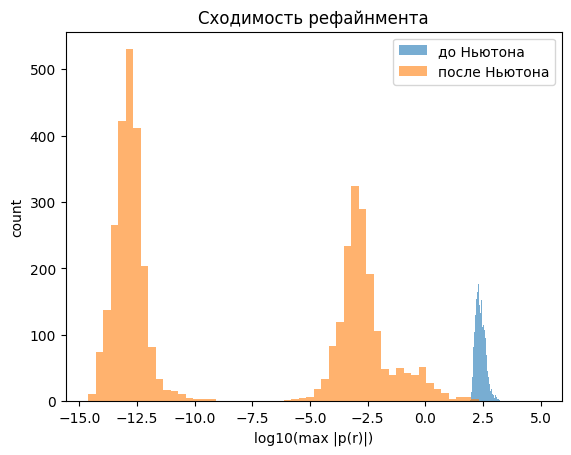

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

r0 = res0.cpu().numpy()
rN = resN.cpu().numpy()

plt.figure()
plt.hist(np.log10(r0+1e-30), bins=60, alpha=0.6, label='до Ньютона')
plt.hist(np.log10(rN+1e-30), bins=60, alpha=0.6, label='после Ньютона')
plt.xlabel('log10(max |p(r)|)')
plt.ylabel('count'); plt.legend(); plt.title('Сходимость рефайнмента')
plt.show()


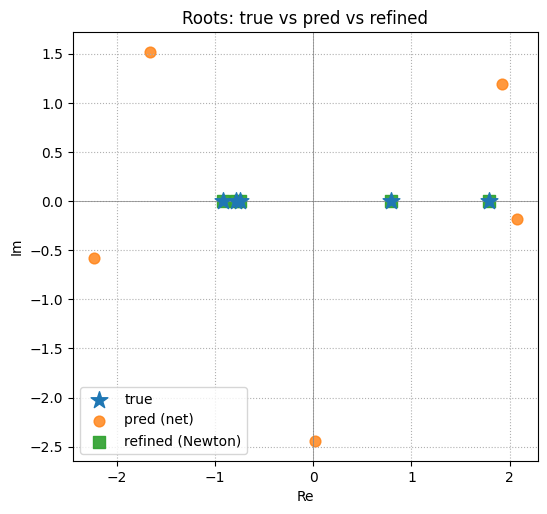

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def to_np(z):
    return z.detach().cpu().numpy()

@torch.no_grad()
def plot_roots_comparison(y_true10, y_pred10, y_refined10, title="Roots: true vs pred vs refined"):
    rt = torch.complex(y_true10[:,0::2], y_true10[:,1::2])   # (B,5)
    rp = torch.complex(y_pred10[:,0::2], y_pred10[:,1::2])   # (B,5)
    rr = torch.complex(y_refined10[:,0::2], y_refined10[:,1::2])  # (B,5)


    t = rt[0]; p = rp[0]; r = rr[0]

    plt.figure(figsize=(6,6))
    plt.axhline(0, lw=0.5, color='gray'); plt.axvline(0, lw=0.5, color='gray')
    plt.scatter(to_np(t.real), to_np(t.imag), marker='*', s=160, label='true', zorder=3)
    plt.scatter(to_np(p.real), to_np(p.imag), marker='o', s=60, label='pred (net)', alpha=0.8)
    plt.scatter(to_np(r.real), to_np(r.imag), marker='s', s=70, label='refined (Newton)', alpha=0.9)

    plt.xlabel('Re'); plt.ylabel('Im'); plt.gca().set_aspect('equal', 'box')
    plt.title(title); plt.legend(); plt.grid(True, ls=':')
    plt.show()

# пример использования (после инференса)
# y_true10 = test_Y[:1]; y_pred10 = pred0[:1]; y_refined10 = predN[:1]
plot_roots_comparison(test_Y[:1], pred0[:1], predN[:1])


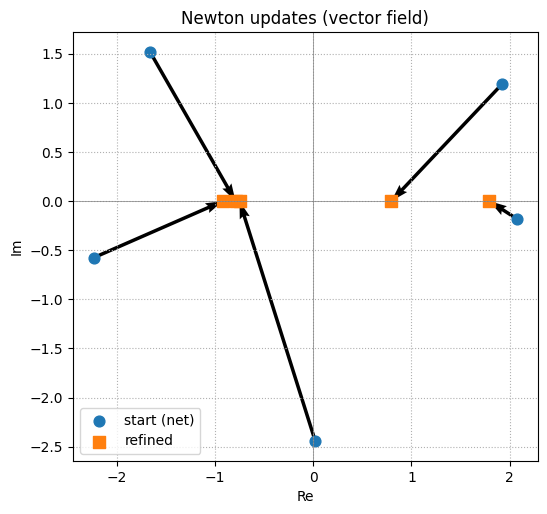

In [ ]:
@torch.no_grad()
def plot_newton_updates(y_pred10, y_refined10, title="Newton updates (vector field)"):
    p = torch.complex(y_pred10[:,0::2], y_pred10[:,1::2])[0]
    r = torch.complex(y_refined10[:,0::2], y_refined10[:,1::2])[0]

    plt.figure(figsize=(6,6))
    plt.axhline(0, lw=0.5, color='gray'); plt.axvline(0, lw=0.5, color='gray')
    # стрелки от pred к refined
    for i in range(5):
        plt.quiver(p[i].real.item(), p[i].imag.item(),
                   (r[i]-p[i]).real.item(), (r[i]-p[i]).imag.item(),
                   angles='xy', scale_units='xy', scale=1)
    plt.scatter(to_np(p.real), to_np(p.imag), s=60, label='start (net)')
    plt.scatter(to_np(r.real), to_np(r.imag), s=80, marker='s', label='refined')
    plt.xlabel('Re'); plt.ylabel('Im'); plt.gca().set_aspect('equal', 'box')
    plt.title(title); plt.legend(); plt.grid(True, ls=':')
    plt.show()

plot_newton_updates(pred0[:1], predN[:1])


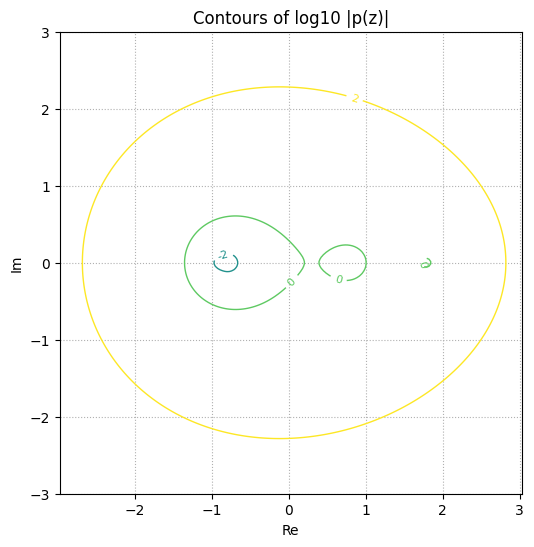

In [ ]:
@torch.no_grad()
def contour_abs_p(coeffs, center=0+0j, span=3.0, pts=300, levels=( -6,-4,-2,0,2 )):
    """
    Рисует контуры log10|p(z)| на квадрате вокруг center.
    levels — логарифмические уровни (в log10).
    """
    cx = complex(center)
    re = np.linspace(cx.real-span, cx.real+span, pts)
    im = np.linspace(cx.imag-span, cx.imag+span, pts)
    Re, Im = np.meshgrid(re, im)
    Z = Re + 1j*Im
    Zt = torch.from_numpy(Z).to(coeffs.device)
    Zc = torch.complex(Zt.real, Zt.imag).unsqueeze(0)  # (1, H, W)

    # батч 1: coeffs[0]
    c = coeffs[:1]
    P = eval_poly(c, Zc)  # (1, H, W)
    val = torch.log10(torch.abs(P).clamp_min(1e-20)).squeeze(0).cpu().numpy()

    plt.figure(figsize=(6,6))
    CS = plt.contour(Re, Im, val, levels=levels, linewidths=1)
    plt.clabel(CS, inline=1, fontsize=8, fmt="%.0f")
    plt.xlabel('Re'); plt.ylabel('Im'); plt.gca().set_aspect('equal', 'box')
    plt.title('Contours of log10 |p(z)|')
    plt.grid(True, ls=':')
    plt.show()

# центр можно взять по среднему истинных корней
center = complex(torch.mean(test_Y[:1,0::2]).item(), torch.mean(test_Y[:1,1::2]).item())
contour_abs_p(test_X[:1], center=center, span=3.0, pts=200)


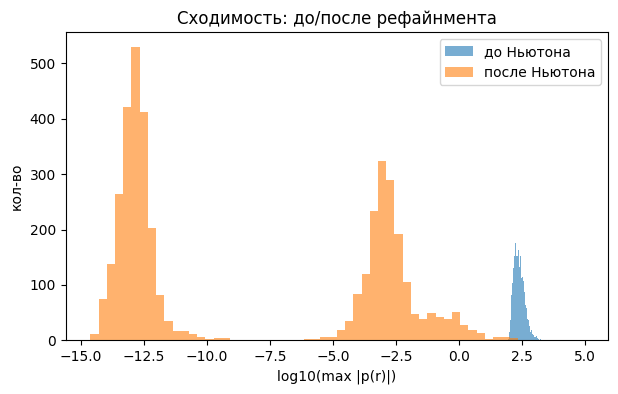

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

r0 = residual_max(test_X, pred0).cpu().numpy()
rN = residual_max(test_X, predN).cpu().numpy()

plt.figure(figsize=(7,4))
plt.hist(np.log10(r0+1e-30), bins=60, alpha=0.6, label='до Ньютона')
plt.hist(np.log10(rN+1e-30), bins=60, alpha=0.6, label='после Ньютона')
plt.xlabel('log10(max |p(r)|)'); plt.ylabel('кол-во'); plt.legend()
plt.title('Сходимость: до/после рефайнмента')
plt.show()


In [ ]:
import numpy as np, torch

torch.set_default_dtype(torch.float64)
device = "cuda" if torch.cuda.is_available() else "cpu"

# 5 известных корней (реальные + комплексная пара)
roots = [2.0, -1.0, 0.5, 1+1j, 1-1j]

# коэффициенты монного полинома x^5 + a4 x^4 + ... + a0
coeffs = np.poly(roots).real  # [1, a4, a3, a2, a1, a0]
a = coeffs[1:]                # [a4..a0] (оригинальные, не скейленные)

# инференс: масштабируем вход как при обучении → сеть → Ньютон
x_scaled = torch.tensor(scaler.transform(a.reshape(1,-1)), device=device)
with torch.no_grad():
    pred = model(x_scaled)
refined = newton_refine(torch.tensor(a.reshape(1,-1), device=device), pred, steps=20)

# проверка p(r)≈0
r = torch.complex(refined[:,0::2], refined[:,1::2])
max_res = torch.max(torch.abs(eval_poly(torch.tensor(a.reshape(1,-1), device=device), r))).item()
print("Smoke test max|p(r)| =", max_res)


Smoke test max|p(r)| = 7.45901062029751e-05


In [ ]:
@torch.no_grad()
def solve_batch_residual_at_eps(X_orig, X_scaled, eps=1e-8, steps=20):
    pred0 = model(torch.tensor(X_scaled, device=device))
    refined = newton_refine(torch.tensor(X_orig, device=device), pred0, steps=steps)
    r = torch.complex(refined[:,0::2], refined[:,1::2])
    res = torch.amax(torch.abs(eval_poly(torch.tensor(X_orig, device=device), r)), dim=1)
    acc = (res <= eps).double().mean().item()
    return acc, res.cpu().numpy()

acc, res = solve_batch_residual_at_eps(X[test], X_scaled[test], eps=1e-8, steps=20)
print(f"Residual@1e-8 on test: {acc*100:.2f}%")


Residual@1e-8 on test: 55.80%


In [ ]:
import itertools

def companion_eigvals(a):
    # a: (5,) = [a4..a0] для x^5 + ...
    a4,a3,a2,a1,a0 = a
    C = np.zeros((5,5), dtype=np.float64)
    C[0,1]=C[1,2]=C[2,3]=C[3,4]=1.0
    C[4,:] = -np.array([a0,a1,a2,a3,a4])
    return np.linalg.eigvals(C)  # (5,)

@torch.no_grad()
def mean_best_perm_dist(a_batch, refined10):

    rp = torch.complex(refined10[:,0::2], refined10[:,1::2]).cpu().numpy()
    dists = []
    for i, a in enumerate(a_batch):
        true_roots = np.roots(np.r_[1.0, a])  # или companion_eigvals(a)
        cand = rp[i]
        best = min(np.mean(np.abs(cand[list(p)] - true_roots)) for p in itertools.permutations(range(5)))
        dists.append(best)
    return float(np.mean(dists))

# пример на 200 тестовых полиномах
idx = np.random.choice(len(test), size=200, replace=False)
pred0 = model(torch.tensor(X_scaled[test][idx], device=device))
refined = newton_refine(torch.tensor(X[test][idx], device=device), pred0, steps=20)
rmd = mean_best_perm_dist(X[test][idx], refined)
print(f"Best-perm mean |Δroot| vs numpy.roots: {rmd:.2e}")


Best-perm mean |Δroot| vs numpy.roots: 2.37e-01


In [ ]:
@torch.no_grad()
def coeff_reconstruction_mse(X_orig, X_scaled, steps=20):
    pred0 = model(torch.tensor(X_scaled, device=device))
    refined = newton_refine(torch.tensor(X_orig, device=device), pred0, steps=steps)
    coeffs_pred = coeffs_from_roots(refined)
    mse = torch.mean((coeffs_pred - torch.tensor(X_orig, device=device))**2).item()
    return mse

mse = coeff_reconstruction_mse(X[test], X_scaled[test], steps=20)
print("MSE(coeffs reconstructed vs original):", mse)


MSE(coeffs reconstructed vs original): 688.7130959729468


In [ ]:
import torch


device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_dtype(torch.float64)


class QuinticMLP(torch.nn.Module):
    def __init__(self, in_dim=5, hidden=256, depth=5, out_dim=10):
        super().__init__()
        layers = [torch.nn.Linear(in_dim, hidden), torch.nn.GELU()]
        for _ in range(depth-1):
            layers += [torch.nn.Linear(hidden, hidden), torch.nn.GELU(), torch.nn.LayerNorm(hidden)]
        layers += [torch.nn.Linear(hidden, out_dim)]
        self.net = torch.nn.Sequential(*layers)
    def forward(self, x): return self.net(x)


model = QuinticMLP()
model.load_state_dict(torch.load("best_mlp.pt", map_location=device))
model.to(device)
model.eval()

print("best_mlp.pt")

@torch.no_grad()
def solve_batch_residual_at_eps(X_orig, X_scaled, eps=1e-8, steps=20):
    pred0 = model(torch.tensor(X_scaled, device=device))
    refined = newton_refine(torch.tensor(X_orig, device=device), pred0, steps=steps)
    r = torch.complex(refined[:,0::2], refined[:,1::2])
    res = torch.amax(torch.abs(eval_poly(torch.tensor(X_orig, device=device), r)), dim=1)
    acc = (res <= eps).double().mean().item()
    return acc, res.cpu().numpy()

acc, res = solve_batch_residual_at_eps(X[test], X_scaled[test], eps=1e-8, steps=20)
print(f"Residual@1e-8 on test: {acc*100:.2f}%")


best_mlp.pt
Residual@1e-8 on test: 55.80%


In [ ]:
depths = [0, 1, 2, 3, 4, 5, 10]
results = []

for d in depths:
    model = QuinticMLP(depth=d, hidden=256).to(device)
    model.train()
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
    loss_fn = torch.nn.MSELoss()

    best_val = 999
    for epoch in range(10):
        model.train()
        pred = model(torch.tensor(X_train_scaled, device=device))
        loss = loss_fn(pred, torch.tensor(Y_train, device=device))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # оценка на валидации
    model.eval()
    with torch.no_grad():
        pred_val = model(torch.tensor(X_val_scaled, device=device))
        val_loss = loss_fn(pred_val, torch.tensor(Y_val, device=device)).item()
        results.append((d, val_loss))

for d, v in results:
    print(f"Depth={d:<2} | Val MSE={v:.4e}")

plt.plot([r[0] for r in results], [r[1] for r in results], marker='o')
plt.xlabel('Hidden layers (depth)')
plt.ylabel('Validation MSE')
plt.title('Effect of depth on model performance')
plt.show()


/tmp/ipython-input-1851972189.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = model(torch.tensor(X_train_scaled, device=device))
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/loss.py:616: UserWarning: Using a target size (torch.Size([28000, 5])) that is different to the input size (torch.Size([28000, 10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (10) must match the size of tensor b (5) at non-singleton dimension 1

In [ ]:
# ==== 0. сетап ===============================================================
import torch, numpy as np, pandas as pd, math, random
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# если train, val, test ещё не определены:
X_train, X_temp, Y_train, Y_temp = train_test_split(X_scaled, X, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

torch.set_default_dtype(torch.float64)
device = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# ==== 1. модель-генератор по глубине =========================================
class QuinticMLP(nn.Module):
    def __init__(self, in_dim=5, hidden=256, depth=5, out_dim=10):
        super().__init__()
        layers = []
        if depth == 0:
            # без скрытых слоёв: чисто линейное отображение
            layers = [nn.Linear(in_dim, out_dim)]
        else:
            layers = [nn.Linear(in_dim, hidden), nn.GELU()]
            for _ in range(depth-1):
                layers += [nn.Linear(hidden, hidden), nn.GELU(), nn.LayerNorm(hidden)]
            layers += [nn.Linear(hidden, out_dim)]
        self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

# ==== 2. лосс как раньше (симметричный через коэфы + residual) ===============
def multiply_poly(p, q):
    n, m = p.shape[-1]-1, q.shape[-1]-1
    out = p.new_zeros(p.shape[0], n+m+1, dtype=torch.complex128)
    for i in range(n+1):
        out[:, i:i+m+1] += p[:, i].unsqueeze(-1) * q
    return out

def coeffs_from_roots(r_reim):
    r = torch.complex(r_reim[:,0::2], r_reim[:,1::2])
    poly = r.new_zeros(r.size(0),1); poly[:,0]=1
    for i in range(5):
        factor = torch.stack([-r[:,i], torch.ones_like(r[:,i])], dim=1)
        poly = multiply_poly(poly, factor)
    coeffs = torch.flip(poly.real, dims=[1])[:,1:]  # a4..a0
    return coeffs

def eval_poly(coeffs, x):
    if x.dim()==1: x = x.unsqueeze(0)
    a4,a3,a2,a1,a0 = [c.unsqueeze(1) for c in coeffs.t()]
    # схема Хорнера для устойчивости
    y = (x + a4)
    y = (y * x + a3)
    y = (y * x + a2)
    y = (y * x + a1)
    y = (y * x + a0)
    return y

def eval_poly_deriv(coeffs, x):
    if x.dim()==1: x = x.unsqueeze(0)
    a4,a3,a2,a1,_ = [c.unsqueeze(1) for c in coeffs.t()]
    y = (5*x + 4*a4)
    y = (y * x + 3*a3)
    y = (y * x + 2*a2)
    y = (y * x + 1*a1)
    return y

@torch.no_grad()
def newton_refine(coeffs, roots10, steps=20, damp0=0.9, tol=1e-14):
    r = torch.complex(roots10[:,0::2], roots10[:,1::2])
    damp = torch.full(r.shape, damp0, dtype=torch.float64, device=r.device).real
    prev = torch.full((r.size(0),), 1e100, device=r.device, dtype=torch.float64)
    for _ in range(steps):
        p  = eval_poly(coeffs, r)
        dp = eval_poly_deriv(coeffs, r)
        good = torch.abs(dp) > 1e-14
        upd = torch.zeros_like(p); upd[good] = p[good]/dp[good]
        r_new = r - damp*upd
        res_old = torch.amax(torch.abs(p), dim=1)
        res_new = torch.amax(torch.abs(eval_poly(coeffs, r_new)), dim=1)
        worse = res_new > res_old
        if worse.any():
            damp = torch.where(worse.unsqueeze(1), 0.5*damp, damp)
            r_new = r - damp*upd
        r = r_new
        res = torch.amax(torch.abs(eval_poly(coeffs, r)), dim=1)
        if torch.all(res < tol): break
        prev = res
    return torch.stack([r.real, r.imag], dim=2).reshape(roots10.size(0), -1)

def loss_fn(pred_roots, coeffs_true, lam=0.1):
    coeffs_pred = coeffs_from_roots(pred_roots)
    coef_mse = torch.mean((coeffs_pred - coeffs_true)**2)
    grid = torch.linspace(-2,2,6, device=coeffs_true.device)
    Xr, Xi = torch.meshgrid(grid, grid, indexing='ij')
    x = torch.complex(Xr.flatten(), Xi.flatten())
    p_true = eval_poly(coeffs_true, x)
    p_pred = eval_poly(coeffs_pred, x)
    residual = torch.mean(torch.abs(p_pred - p_true)**2)
    return coef_mse + lam*residual

@torch.no_grad()
def residual_at_eps(X_orig, X_scaled, model, eps=1e-8, steps=20):
    pred0 = model(torch.tensor(X_scaled, device=device))
    refined = newton_refine(torch.tensor(X_orig, device=device), pred0, steps=steps)
    r = torch.complex(refined[:,0::2], refined[:,1::2])
    res = torch.amax(torch.abs(eval_poly(torch.tensor(X_orig, device=device), r)), dim=1)
    acc = (res <= eps).double().mean().item()
    return acc, res

# ==== 3. данные в тензоры =====================================================
X_train_scaled = torch.from_numpy(X_train)
X_val_scaled   = torch.from_numpy(X_val)
X_test_scaled  = torch.from_numpy(X_test)

X_train_orig = torch.from_numpy(Y_train)
X_val_orig   = torch.from_numpy(Y_val)
X_test_orig  = torch.from_numpy(Y_test)

X_train_orig = torch.from_numpy(X[train])

X_test_orig  = torch.from_numpy(X[test])

train_loader = DataLoader(TensorDataset(X_train_scaled, X_train_orig), batch_size=512, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_scaled,   X_val_orig),   batch_size=512)

# ==== 4. цикл по глубинам =====================================================
depth_list = [0,1,2,3,4,5,6,15]
results = []

for depth in depth_list:
    torch.manual_seed(SEED)  # чтобы условия были одинаковые
    model = QuinticMLP(depth=depth, hidden=256).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=20)

    # --- train: 20 эпох, фикс всё остальное ---
    for epoch in range(20):
        model.train()
        for xb_s, xb_o in train_loader:
            xb_s = xb_s.to(device); xb_o = xb_o.to(device)
            pred = model(xb_s)
            loss = loss_fn(pred, xb_o, lam=0.1)
            opt.zero_grad(); loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
        sch.step()

    # --- val loss для контроля ---
    model.eval()
    with torch.no_grad():
        vloss = 0.0
        for xb_s, xb_o in val_loader:
            xb_s = xb_s.to(device); xb_o = xb_o.to(device)
            vloss += loss_fn(model(xb_s), xb_o).item()
        vloss /= len(val_loader)

    # --- тестовые метрики: Residual@1e-8 и smoke max|p(r)| на одном примере ---
    acc, res_vec = residual_at_eps(X_test_orig.numpy(), X_test_scaled.numpy(), model, eps=1e-8, steps=20)
    # smoke на первом тестовом полиноме
    with torch.no_grad():
        pred0 = model(torch.tensor(X_test_scaled[:1], device=device))
        refined = newton_refine(torch.tensor(X_test_orig[:1], device=device), pred0, steps=40)
        r = torch.complex(refined[:,0::2], refined[:,1::2])
        smoke = torch.max(torch.abs(eval_poly(torch.tensor(X_test_orig[:1], device=device), r))).item()

    results.append({
        "depth": depth,
        "val_loss": vloss,
        "Residual@1e-8_test(%)": round(acc*100, 2),
        "smoke_max|p(r)|": smoke
    })
    print(f"[depth={depth:>2}] val_loss={vloss:.3e}  Resid@1e-8={acc*100:.2f}%  smoke={smoke:.2e}")

# ==== 5. табличка ============================================================
df = pd.DataFrame(results).sort_values("depth").reset_index(drop=True)
df


AssertionError: Size mismatch between tensors

In [ ]:
# ===== СЕТАП ================================================================
import torch, numpy as np, pandas as pd, random
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
torch.set_default_dtype(torch.float64)
device = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# ===== МОДЕЛЬ ===============================================================
class QuinticMLP(nn.Module):
    def __init__(self, in_dim=5, hidden=256, depth=5, out_dim=10):
        super().__init__()
        if depth == 0:
            self.net = nn.Sequential(nn.Linear(in_dim, out_dim))  # чисто линейная
        else:
            layers = [nn.Linear(in_dim, hidden), nn.GELU()]
            for _ in range(depth-1):
                layers += [nn.Linear(hidden, hidden), nn.GELU(), nn.LayerNorm(hidden)]
            layers += [nn.Linear(hidden, out_dim)]
            self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

# ===== УТИЛЫ (как мы уже правили ранее) =====================================
def multiply_poly(p, q):
    n, m = p.shape[-1]-1, q.shape[-1]-1
    out = p.new_zeros(p.shape[0], n+m+1, dtype=torch.complex128)
    for i in range(n+1):
        out[:, i:i+m+1] += p[:, i].unsqueeze(-1) * q
    return out

def coeffs_from_roots(r_reim):
    r = torch.complex(r_reim[:,0::2], r_reim[:,1::2])
    poly = r.new_zeros(r.size(0),1); poly[:,0]=1
    for i in range(5):
        factor = torch.stack([-r[:,i], torch.ones_like(r[:,i])], dim=1)
        poly = multiply_poly(poly, factor)
    coeffs = torch.flip(poly.real, dims=[1])[:,1:]  # a4..a0
    return coeffs

def eval_poly(coeffs, x):
    if x.dim()==1: x = x.unsqueeze(0)
    a4,a3,a2,a1,a0 = [c.unsqueeze(1) for c in coeffs.t()]
    y = (x + a4); y = (y*x + a3); y = (y*x + a2); y = (y*x + a1); y = (y*x + a0)
    return y

def eval_poly_deriv(coeffs, x):
    if x.dim()==1: x = x.unsqueeze(0)
    a4,a3,a2,a1,_ = [c.unsqueeze(1) for c in coeffs.t()]
    y = (5*x + 4*a4); y = (y*x + 3*a3); y = (y*x + 2*a2); y = (y*x + 1*a1)
    return y

@torch.no_grad()
def newton_refine(coeffs, roots10, steps=20, damp0=0.9, tol=1e-14):
    r = torch.complex(roots10[:,0::2], roots10[:,1::2])
    damp = torch.full(r.shape, damp0, dtype=torch.float64, device=r.device).real
    for _ in range(steps):
        p  = eval_poly(coeffs, r); dp = eval_poly_deriv(coeffs, r)
        good = torch.abs(dp) > 1e-14
        upd = torch.zeros_like(p); upd[good] = p[good]/dp[good]
        r = r - damp*upd
        if torch.all(torch.amax(torch.abs(eval_poly(coeffs, r)), dim=1) < tol): break
    return torch.stack([r.real, r.imag], dim=2).reshape(roots10.size(0), -1)

def loss_fn(pred_roots, coeffs_true, lam=0.1):
    coeffs_pred = coeffs_from_roots(pred_roots)               # (B,5)
    coef_mse = torch.mean((coeffs_pred - coeffs_true)**2)
    grid = torch.linspace(-2,2,6, device=coeffs_true.device)
    Xr, Xi = torch.meshgrid(grid, grid, indexing='ij')
    x = torch.complex(Xr.flatten(), Xi.flatten())
    residual = torch.mean(torch.abs(
        eval_poly(coeffs_pred, x) - eval_poly(coeffs_true, x)
    )**2)
    return coef_mse + lam*residual

@torch.no_grad()
def residual_at_eps(X_orig_np, X_scaled_np, model, eps=1e-8, steps=20):
    Xo = torch.from_numpy(X_orig_np).to(device)
    Xs = torch.from_numpy(X_scaled_np).to(device)
    pred0 = model(Xs)
    refined = newton_refine(Xo, pred0, steps=steps)
    r = torch.complex(refined[:,0::2], refined[:,1::2])
    res = torch.amax(torch.abs(eval_poly(Xo, r)), dim=1)
    acc = (res <= eps).double().mean().item()
    return acc, res

# ===== ДАННЫЕ (исходные и скейленные должны уже быть) ========================
# X_scaled: (N,5) скейленные коэффициенты; X: (N,5) оригинальные коэффициенты
from sklearn.model_selection import train_test_split

# Разбиваем данные на train / val / test
# (70% — обучение, 15% — валидация, 15% — тест)
X_train, X_temp, Y_train, Y_temp = train_test_split(X_scaled, X, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

# ДОЛЖНЫ быть заранее разбиты индексы/массивы train/val/test
X_train_scaled = torch.from_numpy(X_train)
X_val_scaled   = torch.from_numpy(X_val)
X_test_scaled  = torch.from_numpy(X_test)

X_train_orig = torch.from_numpy(Y_train)
X_val_orig   = torch.from_numpy(Y_val)
X_test_orig  = torch.from_numpy(Y_test)


train_loader = DataLoader(TensorDataset(X_train_scaled, X_train_orig), batch_size=512, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_scaled,   X_val_orig),   batch_size=512)

# ===== ЭКСПЕРИМЕНТ ПО ГЛУБИНЕ ===============================================
depths = [0,1,2,3,4,5,6,15]
results = []

for d in depths:
    torch.manual_seed(SEED)
    model = QuinticMLP(depth=d, hidden=256).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=20)

    # train 20 эпох
    for _ in range(20):
        model.train()
        for xb_s, xb_o in train_loader:
            xb_s, xb_o = xb_s.to(device), xb_o.to(device)
            pred = model(xb_s)                          # (B,10)
            loss = loss_fn(pred, xb_o, lam=0.1)         # сравнение через коэффициенты (оба (B,5))
            opt.zero_grad(); loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
        sch.step()

    # val loss
    model.eval()
    with torch.no_grad():
        vloss = 0.0
        for xb_s, xb_o in val_loader:
            xb_s, xb_o = xb_s.to(device), xb_o.to(device)
            vloss += loss_fn(model(xb_s), xb_o).item()
        vloss /= len(val_loader)

    # тестовая метрика
    acc, res = residual_at_eps(X[test], X_scaled[test], model, eps=1e-8, steps=20)
    results.append({"depth": d, "val_loss": vloss, "Residual@1e-8(%)": round(acc*100,2)})

# табличка
df = pd.DataFrame(results).sort_values("depth").reset_index(drop=True)
print(df)


   depth     val_loss  Residual@1e-8(%)
0      0  3660.516733             91.27
1      1    81.011583             86.72
2      2     4.143090             85.25
3      3     2.280569             90.18
4      4     1.721102             89.70
5      5     1.822445             90.38
6      6     3.162152             95.67
7     15    66.735973             91.57


In [ ]:
# ===== СЕТАП ================================================================
import torch, numpy as np, pandas as pd, random
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
torch.set_default_dtype(torch.float64)
device = "cuda" if torch.cuda.is_available() else "cpu"
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# ===== МОДЕЛЬ ===============================================================
class QuinticMLP(nn.Module):
    def __init__(self, in_dim=5, hidden=256, depth=5, out_dim=10):
        super().__init__()
        if depth == 0:
            self.net = nn.Sequential(nn.Linear(in_dim, out_dim))  # чисто линейная
        else:
            layers = [nn.Linear(in_dim, hidden), nn.GELU()]
            for _ in range(depth-1):
                layers += [nn.Linear(hidden, hidden), nn.GELU(), nn.LayerNorm(hidden)]
            layers += [nn.Linear(hidden, out_dim)]
            self.net = nn.Sequential(*layers)
    def forward(self, x): return self.net(x)

# ===== УТИЛЫ (как мы уже правили ранее) =====================================
def multiply_poly(p, q):
    n, m = p.shape[-1]-1, q.shape[-1]-1
    out = p.new_zeros(p.shape[0], n+m+1, dtype=torch.complex128)
    for i in range(n+1):
        out[:, i:i+m+1] += p[:, i].unsqueeze(-1) * q
    return out

def coeffs_from_roots(r_reim):
    r = torch.complex(r_reim[:,0::2], r_reim[:,1::2])
    poly = r.new_zeros(r.size(0),1); poly[:,0]=1
    for i in range(5):
        factor = torch.stack([-r[:,i], torch.ones_like(r[:,i])], dim=1)
        poly = multiply_poly(poly, factor)
    coeffs = torch.flip(poly.real, dims=[1])[:,1:]  # a4..a0
    return coeffs

def eval_poly(coeffs, x):
    if x.dim()==1: x = x.unsqueeze(0)
    a4,a3,a2,a1,a0 = [c.unsqueeze(1) for c in coeffs.t()]
    y = (x + a4); y = (y*x + a3); y = (y*x + a2); y = (y*x + a1); y = (y*x + a0)
    return y

def eval_poly_deriv(coeffs, x):
    if x.dim()==1: x = x.unsqueeze(0)
    a4,a3,a2,a1,_ = [c.unsqueeze(1) for c in coeffs.t()]
    y = (5*x + 4*a4); y = (y*x + 3*a3); y = (y*x + 2*a2); y = (y*x + 1*a1)
    return y

@torch.no_grad()
def newton_refine(coeffs, roots10, steps=20, damp0=0.9, tol=1e-14):
    r = torch.complex(roots10[:,0::2], roots10[:,1::2])
    damp = torch.full(r.shape, damp0, dtype=torch.float64, device=r.device).real
    for _ in range(steps):
        p  = eval_poly(coeffs, r); dp = eval_poly_deriv(coeffs, r)
        good = torch.abs(dp) > 1e-14
        upd = torch.zeros_like(p); upd[good] = p[good]/dp[good]
        r = r - damp*upd
        if torch.all(torch.amax(torch.abs(eval_poly(coeffs, r)), dim=1) < tol): break
    return torch.stack([r.real, r.imag], dim=2).reshape(roots10.size(0), -1)

def loss_fn(pred_roots, coeffs_true, lam=0.1):
    coeffs_pred = coeffs_from_roots(pred_roots)               # (B,5)
    coef_mse = torch.mean((coeffs_pred - coeffs_true)**2)
    grid = torch.linspace(-2,2,6, device=coeffs_true.device)
    Xr, Xi = torch.meshgrid(grid, grid, indexing='ij')
    x = torch.complex(Xr.flatten(), Xi.flatten())
    residual = torch.mean(torch.abs(
        eval_poly(coeffs_pred, x) - eval_poly(coeffs_true, x)
    )**2)
    return coef_mse + lam*residual

@torch.no_grad()
def residual_at_eps(X_orig_np, X_scaled_np, model, eps=1e-8, steps=20):
    Xo = torch.from_numpy(X_orig_np).to(device)
    Xs = torch.from_numpy(X_scaled_np).to(device)
    pred0 = model(Xs)
    refined = newton_refine(Xo, pred0, steps=steps)
    r = torch.complex(refined[:,0::2], refined[:,1::2])
    res = torch.amax(torch.abs(eval_poly(Xo, r)), dim=1)
    acc = (res <= eps).double().mean().item()
    return acc, res

# ===== ДАННЫЕ (исходные и скейленные должны уже быть) ========================
# X_scaled: (N,5) скейленные коэффициенты; X: (N,5) оригинальные коэффициенты
from sklearn.model_selection import train_test_split

# Разбиваем данные на train / val / test
# (70% — обучение, 15% — валидация, 15% — тест)
X_train, X_temp, Y_train, Y_temp = train_test_split(X_scaled, X, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

# ДОЛЖНЫ быть заранее разбиты индексы/массивы train/val/test
X_train_scaled = torch.from_numpy(X_train)
X_val_scaled   = torch.from_numpy(X_val)
X_test_scaled  = torch.from_numpy(X_test)

X_train_orig = torch.from_numpy(Y_train)
X_val_orig   = torch.from_numpy(Y_val)
X_test_orig  = torch.from_numpy(Y_test)


train_loader = DataLoader(TensorDataset(X_train_scaled, X_train_orig), batch_size=512, shuffle=True)
val_loader   = DataLoader(TensorDataset(X_val_scaled,   X_val_orig),   batch_size=512)

# ===== ЭКСПЕРИМЕНТ ПО ГЛУБИНЕ ===============================================
depths = [7,8,9,10,11,12,13,14,15]
results = []

for d in depths:
    torch.manual_seed(SEED)
    model = QuinticMLP(depth=d, hidden=256).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    sch = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=20)

    # train 20 эпох
    for _ in range(20):
        model.train()
        for xb_s, xb_o in train_loader:
            xb_s, xb_o = xb_s.to(device), xb_o.to(device)
            pred = model(xb_s)                          # (B,10)
            loss = loss_fn(pred, xb_o, lam=0.1)         # сравнение через коэффициенты (оба (B,5))
            opt.zero_grad(); loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
        sch.step()

    # val loss
    model.eval()
    with torch.no_grad():
        vloss = 0.0
        for xb_s, xb_o in val_loader:
            xb_s, xb_o = xb_s.to(device), xb_o.to(device)
            vloss += loss_fn(model(xb_s), xb_o).item()
        vloss /= len(val_loader)

    # тестовая метрика
    acc, res = residual_at_eps(X[test], X_scaled[test], model, eps=1e-8, steps=20)
    results.append({"depth": d, "val_loss": vloss, "Residual@1e-8(%)": round(acc*100,2)})

# табличка
df = pd.DataFrame(results).sort_values("depth").reset_index(drop=True)
print(df)


   depth   val_loss  Residual@1e-8(%)
0      7   2.028477             91.75
1      8   2.647249             90.25
2      9   2.619167             93.10
3     10   3.074320             91.22
4     11   3.335315             89.38
5     12   5.350054             93.23
6     13   7.009549             87.20
7     14   4.287250             92.35
8     15  66.735973             91.57


  depth     val_loss  Residual@1e-8(%)
0      0  3660.516733             91.27
1      1    81.011583             86.72
2      2     4.143090             85.25
3      3     2.280569             90.18
4      4     1.721102             89.70
5      5     1.822445             90.38
6      6     3.162152             95.67
7     15    66.735973             91.570      7   2.028477             91.75
1      8   2.647249             90.25
2      9   2.619167             93.10
3     10   3.074320             91.22
4     11   3.335315             89.38
5     12   5.350054             93.23
6     13   7.009549             87.20
7     14   4.287250             92.35
8     15  66.735973             91.57

In [ ]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from openai import OpenAI
from dotenv import load_dotenv


USE_OPENAI = True
try:
    load_dotenv()
    OPENAI_API_KEY = os.getenv("OPENAI_API_KEY", "")
    if not OPENAI_API_KEY:
        raise ValueError("OPENAI_API_KEY не найден в переменных окружения")
    client = OpenAI(api_key=OPENAI_API_KEY)
except Exception as e:
    print(f"Ошибка инициализации OpenAI: {e}")
    USE_OPENAI = False


# Инициализация клиента OpenAI
client = OpenAI(api_key=OPENAI_API_KEY)

def poly_to_string(coeffs):
    # coeffs: highest degree -> constant
    #  "x^5 + 2x^4 - 3x + 7 = 0"
    terms = []
    deg = len(coeffs)-1
    for i, c in enumerate(coeffs):
        power = deg - i
        c = int(c)
        if c == 0: continue
        if power == 0:
            term = f"{c}"
        elif power == 1:
            if abs(c) == 1: term = "x" if c > 0 else "-x"
            else: term = f"{c}x"
        else:
            if abs(c) == 1: term = f"x^{power}" if c > 0 else f"-x^{power}"
            else: term = f"{c}x^{power}"
        terms.append(term)
    if not terms:
        expr = "0"
    else:
        expr = terms[0]
        for t in terms[1:]:
            if t.startswith("-"): expr += " " + t
            else: expr += " + " + t
    return expr + " = 0"

def make_quintic_strings(n, rng):
    rows = []
    for _ in range(n):
        # монический x^5 + a4 x^4 + ... + a0
        a = rng.integers(-7, 8, size=5)  # симпатичные целые
        coeffs = np.concatenate([[1], a])
        s = poly_to_string(coeffs)
        rows.append((s, "quintic"))
    return rows

def make_other_poly_strings(n, rng):
    rows = []
    degrees = [1,2,3,4,6,7]  # всё кроме 5
    for _ in range(n):
        d = int(rng.choice(degrees))
        # случайно монический/немонический
        lead = int(rng.choice([1, rng.integers(-5,6)]))
        if lead == 0: lead = 1
        coeffs = [lead] + list(rng.integers(-7,8,size=d).tolist())
        s = poly_to_string(np.array(coeffs))
        rows.append((s, "other_poly"))
    return rows

def make_noise_strings(n, rng):
    vocab = ["alpha","beta","gamma","delta","foo","bar","lorem","ipsum","hello","world","42","2025"]
    rows=[]
    for _ in range(n):
        k = rng.integers(2,6)
        tokens = rng.choice(vocab, size=k, replace=True).tolist()
        s = " ".join(tokens)

        if rng.random() < 0.3:
            s += " " + rng.choice(["@@@","***","???","###"])
        rows.append((s, "nonsense"))
    return rows

def maybe_openai_explanation(text, label):
    if not USE_OPENAI:
        if label == "quintic":
            return "Это полином 5-й степени (есть x^5). Решать солвером квинтиков."
        elif label == "other_poly":
            return "Это полином другой степени (не 5). Следует отказаться."
        else:
            return "Это не полином. Следует отказаться."

    prompt = f"Classify the string and give a short explanation in Russian.\nText: {text}\nLabel: {label}\nExplain briefly why."
    resp = client.chat.completions.create(
        model="gpt-4.1-mini",
        messages=[{"role":"user", "content":prompt}],
        temperature=0.2,
     )
    return resp.choices[0].message.content.strip()

if __name__ == "__main__":
    rng = np.random.default_rng(7)
    out_dir = Path("data/classifier"); out_dir.mkdir(parents=True, exist_ok=True)

    quintic_n = 900      # 700–1000
    other_n   = 600      # 500–700
    noise_n   = 600      # 500–700

    rows = []
    rows += make_quintic_strings(quintic_n, rng)
    rows += make_other_poly_strings(other_n, rng)
    rows += make_noise_strings(noise_n, rng)

    rng.shuffle(rows)

    # Собираем CSV: input_text,label,explanation
    data = []
    for s, label in rows:
        expl = maybe_openai_explanation(s, label)
        data.append({"input_text": s, "label": label, "explanation": expl})

    df = pd.DataFrame(data)
    df.to_csv(out_dir/"dataset.csv", index=False)

    # Сплиты и «тесты с ответами/без»
    n = len(df)
    train = df.iloc[:int(0.7*n)]
    valid = df.iloc[int(0.7*n):int(0.85*n)]
    test  = df.iloc[int(0.85*n):]

    train.to_csv(out_dir/"train.csv", index=False)
    valid.to_csv(out_dir/"valid.csv", index=False)
    test.to_csv(out_dir/"test_with_answers.csv", index=False)
    test[["input_text"]].to_csv(out_dir/"test_without_answers.csv", index=False)

    print("Saved classifier CSVs in", out_dir)


Ошибка инициализации OpenAI: OPENAI_API_KEY не найден в переменных окружения
Saved classifier CSVs in data/classifier


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path

def sample_quintic_roots(rng, rmin=0.3, rmax=2.0, pair_prob=0.6):
    roots = []
    remaining = 5
    while remaining > 0:
        if remaining >= 2 and rng.random() < pair_prob:
            r = rng.uniform(rmin, rmax)
            theta = rng.uniform(0, np.pi)  # верхняя полуплоскость
            z = r * (np.cos(theta) + 1j*np.sin(theta))
            roots += [z, np.conj(z)]
            remaining -= 2
        else:
            sign = rng.choice([-1, 1])
            r = rng.uniform(rmin, rmax) * sign
            roots.append(r + 0j)
            remaining -= 1
    roots = np.array(roots, dtype=np.complex128)
    rng.shuffle(roots)
    return roots

def roots_to_coeffs_targets(roots):
    # np.poly -> [1, a4, a3, a2, a1, a0] для монческого квинтика
    coeffs = np.poly(roots)
    coeffs = np.real_if_close(coeffs, tol=1e-10)
    a = coeffs[1:].astype(float)  # a4..a0
    r_sorted = sorted(roots, key=lambda z: (np.real(z), np.imag(z)))
    y = []
    for z in r_sorted:
        y += [float(np.real(z)), float(np.imag(z))]
    return a, y  # (5,), (10,)

def make_dataset(n, seed=42):
    rng = np.random.default_rng(seed)
    rows = []
    for _ in range(n):
        roots = sample_quintic_roots(rng)
        a, y = roots_to_coeffs_targets(roots)
        row = {
            "a4": a[0], "a3": a[1], "a2": a[2], "a1": a[3], "a0": a[4],
        }
        for i in range(5):
            row[f"r{i+1}_re"] = y[2*i]
            row[f"r{i+1}_im"] = y[2*i+1]
        rows.append(row)
    return pd.DataFrame(rows)

if __name__ == "__main__":
    out_dir = Path("data/regression"); out_dir.mkdir(parents=True, exist_ok=True)

    df_train = make_dataset(1000, seed=1)
    df_val   = make_dataset(300,  seed=2)
    df_test  = make_dataset(300,  seed=3)

    df_train.to_csv(out_dir/"train.csv", index=False)
    df_val.to_csv(out_dir/"val.csv", index=False)
    df_test.to_csv(out_dir/"test.csv", index=False)
    print("Saved:", out_dir/"train.csv", out_dir/"val.csv", out_dir/"test.csv")


Saved: data/regression/train.csv data/regression/val.csv data/regression/test.csv


In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch, torch.nn as nn
from sklearn.preprocessing import StandardScaler

# ---- мини-генерация данных: корни -> коэффициенты (мон. квинтики) ----
def sample_quintic_roots(n, seed=0, rmin=0.3, rmax=2.0, pair_prob=0.6):
    rng = np.random.default_rng(seed)
    all_roots = []
    for _ in range(n):
        roots, left = [], 5
        while left > 0:
            if left >= 2 and rng.random() < pair_prob:
                r = rng.uniform(rmin, rmax)
                th = rng.uniform(0, np.pi)
                z = r*(np.cos(th)+1j*np.sin(th))
                roots += [z, np.conj(z)]; left -= 2
            else:
                sign = rng.choice([-1,1])
                r = rng.uniform(rmin, rmax)*sign
                roots += [r+0j]; left -= 1
        rng.shuffle(roots)
        all_roots.append(np.array(roots, np.complex128))
    return all_roots

def roots_to_row(roots):
    coeffs = np.poly(roots)                        # [1, a4, a3, a2, a1, a0]
    coeffs = np.real_if_close(coeffs, tol=1e-10)
    a = coeffs[1:].astype(float)                   # a4..a0
    r_sorted = sorted(roots, key=lambda z: (np.real(z), np.imag(z)))
    y = []
    for z in r_sorted:
        y += [float(np.real(z)), float(np.imag(z))]  # re, im x5
    return a, np.array(y, float)

def make_df(n, seed):
    rows=[]
    for r in sample_quintic_roots(n, seed=seed):
        a,y = roots_to_row(r)
        row = dict(a4=a[0], a3=a[1], a2=a[2], a1=a[3], a0=a[4])
        for i in range(5):
            row[f"r{i+1}_re"] = y[2*i]; row[f"r{i+1}_im"] = y[2*i+1]
        rows.append(row)
    return pd.DataFrame(rows)

# ---- маленькие датасеты (быстро) ----
df_tr = make_df(200, seed=1)
df_va = make_df(50,  seed=2)

Xtr = df_tr[["a4","a3","a2","a1","a0"]].values.astype(np.float32)
Ytr = df_tr[[f"r{i}_re" for i in range(1,6)] + [f"r{i}_im" for i in range(1,6)]].values.astype(np.float32)
Xva = df_va[["a4","a3","a2","a1","a0"]].values.astype(np.float32)
Yva = df_va[[f"r{i}_re" for i in range(1,6)] + [f"r{i}_im" for i in range(1,6)]].values.astype(np.float32)

scaler = StandardScaler().fit(Xtr)
Xtr_s = scaler.transform(Xtr).astype(np.float32)
Xva_s = scaler.transform(Xva).astype(np.float32)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)
print(torch.version.cuda)

# ---- простой ResMLP (минимум, без Hungarian и DK — чтобы было мгновенно) ----
class ResBlock(nn.Module):
    def __init__(self, d):
        super().__init__()
        self.ln1 = nn.LayerNorm(d)
        self.fc1 = nn.Linear(d, d)
        self.act = nn.GELU()
        self.ln2 = nn.LayerNorm(d)
        self.fc2 = nn.Linear(d, d)
    def forward(self, x):
        h = self.fc1(self.ln1(x))
        h = self.act(h)
        h = self.fc2(self.ln2(h))
        return x + h

class ResMLP(nn.Module):
    def __init__(self, d_in=5, d=64, depth=3, d_out=10):
        super().__init__()
        self.inp = nn.Linear(d_in, d)
        self.blocks = nn.ModuleList([ResBlock(d) for _ in range(depth)])
        self.out = nn.Linear(d, d_out)
    def forward(self, x):
        h = self.inp(x)
        for b in self.blocks:
            h = b(h)
        return self.out(h)

torch.manual_seed(0)
model = ResMLP(d_in=5, d=64, depth=3, d_out=10).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

Xtr_t = torch.tensor(Xtr_s, device=device)
Ytr_t = torch.tensor(Ytr,   device=device)
Xva_t = torch.tensor(Xva_s, device=device)
Yva_t = torch.tensor(Yva,   device=device)

def mse_t(a,b): return torch.mean((a-b)**2)

print("5 эпох, batch=64")
val_curve = []
for ep in range(5):
    model.train()

    idx = torch.randperm(Xtr_t.shape[0], device=device)[:64]
    xb, yb = Xtr_t[idx], Ytr_t[idx]
    opt.zero_grad(set_to_none=True)
    pred = model(xb)
    loss = mse_t(pred, yb)
    loss.backward(); opt.step()

    model.eval()
    with torch.no_grad():
        val = mse_t(model(Xva_t), Yva_t).item()
    val_curve.append(val)
    print(f"epoch {ep+1}/5  |  train_mse={loss.item():.4f}  val_mse={val:.4f}")

plt.figure()
plt.plot(val_curve, marker="o")
plt.title("Validation MSE (smoke test)")
plt.xlabel("epoch"); plt.ylabel("val MSE"); plt.show()
print("done")

import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")


Device: cpu
12.6
5 эпох, batch=64


RuntimeError: mat1 and mat2 must have the same dtype, but got Float and Double